In [1]:
!pip install keras-cv --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 47.3 MB/s eta 0:00:00


In [2]:
# 라이브러리 불러오기
import keras_cv
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image
from IPython.display import Image as IImage

Using TensorFlow backend


In [3]:
# 혼합 정밀도 활성화하기
keras.mixed_precision.set_global_policy("mixed_float16")

# Stable Diffusion 모델 인스턴스화하기
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [4]:
# 두 개의 프롬프트를 정의하기
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"

# 보간 단계 수를 정의하기
interpolation_steps = 5

# 첫 번째 프롬프트를 텍스트 인코딩으로 변환하기
encoding_1 = tf.squeeze(model.encode_text(prompt_1))
# 두 번째 프롬프트를 텍스트 인코딩으로 변환하기
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

# 첫 번째와 두 번째 인코딩 사이를 보간하기
interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

# 잠재 매니폴드의 크기를 출력하기
print(f"Encoding shape: {encoding_1.shape}")

492466864/492466864 [==============================] - 2s 0us/step
Encoding shape: (77, 768)


In [5]:
# 시드 설정하기
seed = 12345

In [6]:
# 노이즈 생성하기
noise = tf.random.normal((512 // 8, 512 // 8, 4), # 512 // 8 크기의 텐서로 랜덤 노이즈를 생성하기
                         seed=seed,
                         dtype=tf.dtypes.float16) # 데이터 타입은 float16으로 설정하기

In [7]:
# 모델을 사용하여 이미지를 생성하기
images = model.generate_image(
    interpolated_encodings,  # 보간된 인코딩
    batch_size=interpolation_steps,  # 배치 크기
    diffusion_noise=noise,  # 확산 노이즈
)

198180272/198180272 [==============================] - 1s 0us/step


In [8]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    # rubber_band가 True이면
    # 이미지 시퀀스를 역순으로 추가하여
    # 반복 애니메이션을 만들기
    if rubber_band:
        images += images[2:-1][::-1]
    # 첫 번째 이미지를 저장하고
    # 나머지 이미지를 추가하여 GIF로 저장하기
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0
    )

# 이미지 배열을 PIL 이미지 객체로 변환하여 "doggo-and-fruit-5.gif"로 저장하기
export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True
)

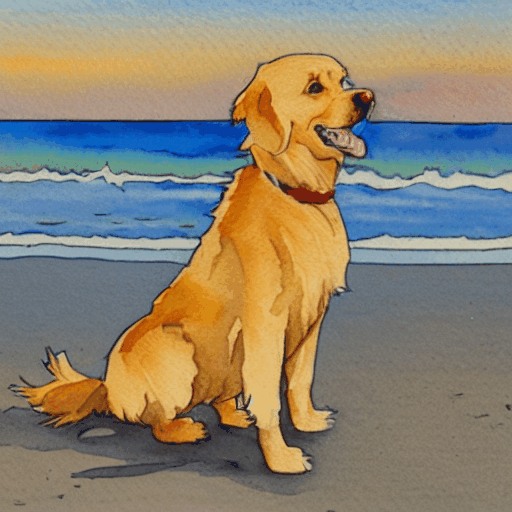

In [9]:
# "doggo-and-fruit-5.gif" 파일을 이미지로 표시하기
IImage("doggo-and-fruit-5.gif")

In [10]:
# 이미지 배열을 PIL 이미지 객체로 변환하여 "doggo-and-fruit-5.gif"로 저장하기
export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True
)

In [11]:
interpolation_steps = 50
batch_size = 2
batches = interpolation_steps // batch_size

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("doggo-and-fruit-50.gif", images, rubber_band=True)

25/25 [==============================] - 11s 444ms/step


In [12]:
interpolation_steps = 200
batch_size = 2
batches = interpolation_steps // batch_size

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("doggo-and-fruit-200.gif", images, rubber_band=True)

25/25 [==============================] - 11s 446ms/step


In [13]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 6
batch_size = 2
batches = (interpolation_steps**2) // batch_size

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))
encoding_3 = tf.squeeze(model.encode_text(prompt_3))
encoding_4 = tf.squeeze(model.encode_text(prompt_4))

interpolated_encodings = tf.linspace(
    tf.linspace(encoding_1, encoding_2, interpolation_steps),
    tf.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = tf.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []

In [14]:
def plot_grid(
    images,
    path,
    grid_size,
    scale=2,
):
    fig = plt.figure(figsize=(grid_size * scale, grid_size * scale))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.axis("off")
    images = images.astype(int)
    for row in range(grid_size):
        for col in range(grid_size):
            index = row * grid_size + col
            plt.subplot(grid_size, grid_size, index + 1)
            plt.imshow(images[index].astype("uint8"))
            plt.axis("off")
            plt.margins(x=0, y=0)
    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )

In [15]:
for batch in range(batches):
    images.append(
        model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            diffusion_noise=noise,
        )
    )

50/50 [==============================] - 22s 445ms/step


<ipython-input-14-dac33a51ba90>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid_size, grid_size, index + 1)


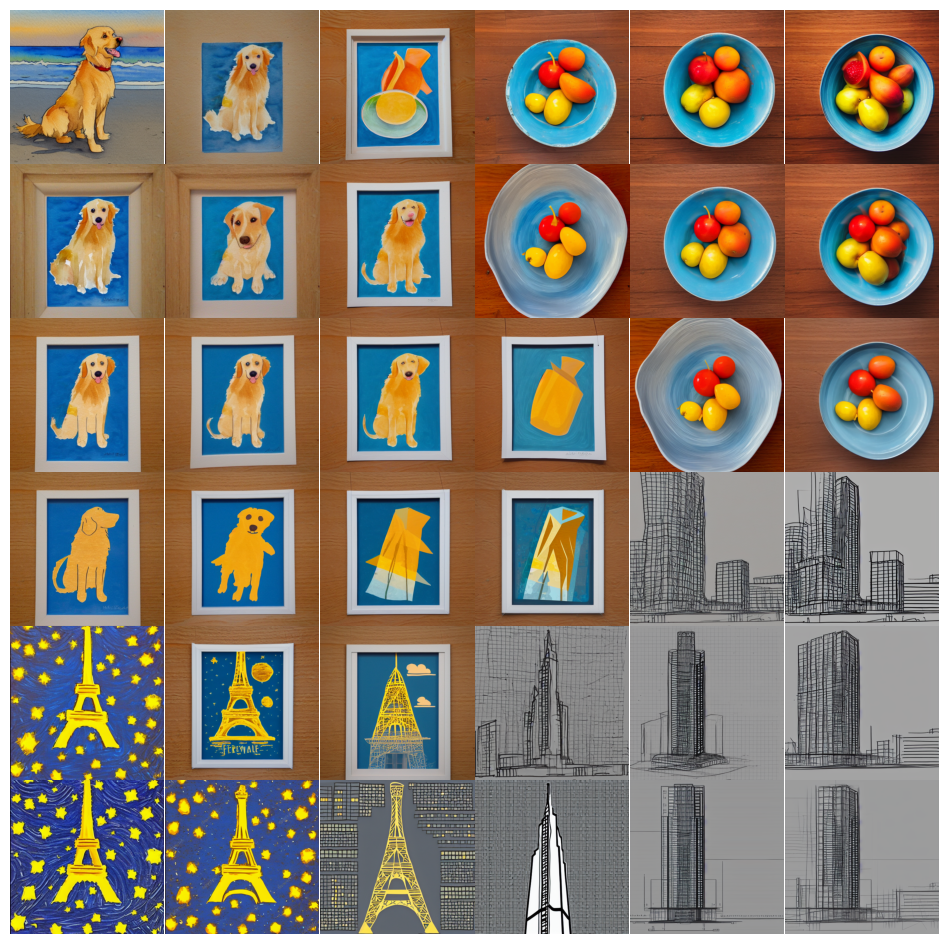

In [16]:
images = np.concatenate(images)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)